# From Neurons to Networks: Exploring Deep Learning Algorithms

Roderick Perez, Ph.D.
OMV

---

In [2]:
!pip install yfinance tensorflow matplotlib scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.5/939.5 kB 15.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached wheel-0.44.0-py3-none-any.whl.metadata (2.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.4/601.4 MB 19.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 106.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 123.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 74.5 MB/s eta 0:00:00
   

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import datetime

2024-10-22 21:26:50.802341: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-22 21:26:50.817500: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-22 21:26:51.254918: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-22 21:26:51.358467: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-22 21:26:51.471823: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

1) Load Financial Data from Yahoo Finance

In [5]:
# Function to load financial data
def load_financial_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data['Adj Close'].values.reshape(-1, 1), data  # Returning adjusted close prices

In [6]:
# Example: Load NVIDIA stock data
ticker = "NVDA"
start_date = "2015-01-01"
end_date = datetime.date.today().strftime("%Y-%m-%d")
data, raw_data = load_financial_data(ticker, start_date, end_date)

[*********************100%***********************]  1 of 1 completed


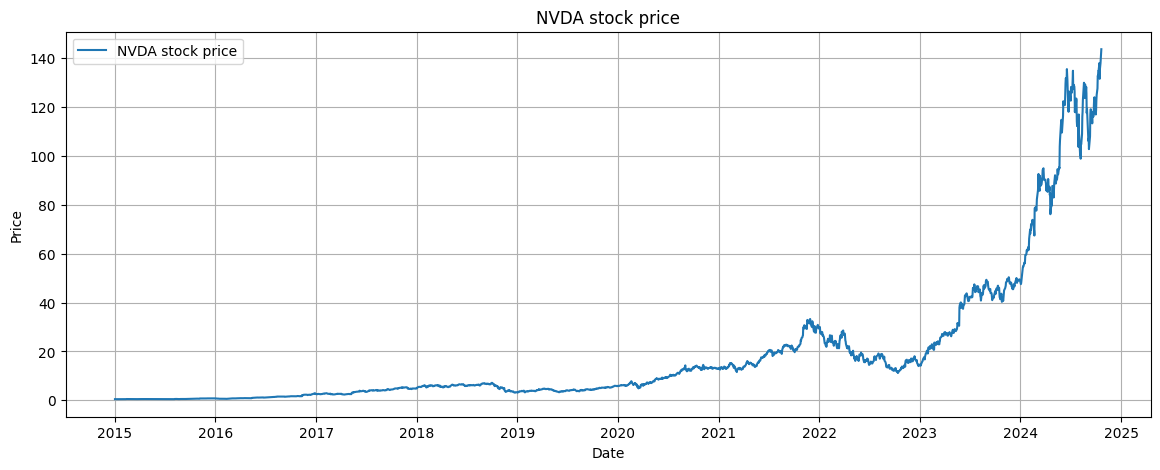

In [9]:
# Plot the data
plt.figure(figsize=(14, 5))
plt.plot(raw_data.index, data, label=f"{ticker} stock price")
plt.title(f"{ticker} stock price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

2. Split Dataset into Train, Test, and Validation Sets

We'll split the data into training (60%), testing (20%), and validation (20%) sets. Data will be scaled using MinMaxScaler for LSTM input.

In [7]:
# Normalize the data to range [0, 1] for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split data into training, validation, and test sets
train_size = int(len(scaled_data) * 0.6)
test_size = int(len(scaled_data) * 0.2)
val_size = len(scaled_data) - train_size - test_size

train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:train_size + test_size]
val_data = scaled_data[train_size + test_size:]

print(f"Train size: {len(train_data)}, Test size: {len(test_data)}, Validation size: {len(val_data)}")

Train size: 1480, Test size: 493, Validation size: 494


3. Define Model Parameters (Learning Rate, Window Size, etc.)

In [10]:
# Hyperparameters
window_size = 60  # Number of days to look back
batch_size = 64
epochs = 10
learning_rate = 0.001

4. Prepare Data for LSTM and Define Model Architecture

In [11]:
# Function to create windows for LSTM input
def create_dataset(dataset, window_size):
    X, y = [], []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:i + window_size])
        y.append(dataset[i + window_size])
    return np.array(X), np.array(y)

# Prepare the training, testing, and validation data
X_train, y_train = create_dataset(train_data, window_size)
X_test, y_test = create_dataset(test_data, window_size)
X_val, y_val = create_dataset(val_data, window_size)

# Reshape X for LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

# Define the LSTM model architecture
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(window_size, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5. Show Model Summary

In [12]:
# Show model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

6. Train the Model

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 3.7635e-04 - val_loss: 0.0039
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 2.5468e-05 - val_loss: 0.0022
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 1.9273e-05 - val_loss: 0.0020
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 1.5346e-05 - val_loss: 0.0024
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 1.1537e-05 - val_loss: 0.0027
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 1.1945e-05 - val_loss: 0.0032
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 1.0364e-05 - val_loss: 0.0026
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 1.4232e-05 - val_loss: 0.0017
Epoch 9/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 8.4318e-06 - val_loss: 0.0016
Epoch 10/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 1.0049e-05 - val_loss: 0.0059


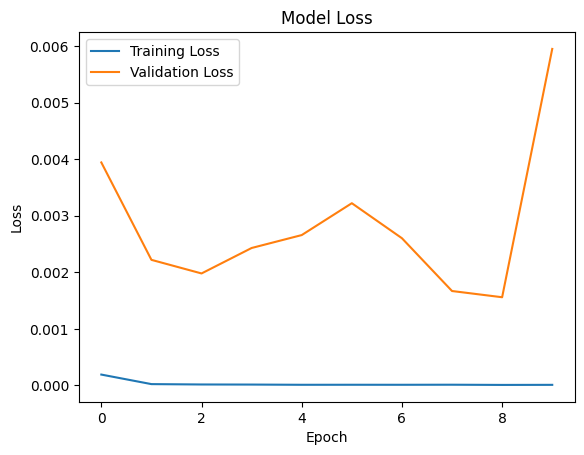

In [13]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

7. Save the Model

In [14]:
# Save the model
model.save("lstm_nvidia_model.h5")

8. Load the Model

In [15]:
# Load the model
from tensorflow.keras.models import load_model
loaded_model = load_model("lstm_nvidia_model.h5")

9. Make Predictions for Future Days

In [20]:
prediction_days = 365

In [21]:
# Function to predict future values
def predict_future_days(model, data, prediction_days, window_size):
    predictions = []
    last_window = data[-window_size:]
    
    for _ in range(prediction_days):
        input_data = last_window.reshape((1, window_size, 1))
        predicted_value = model.predict(input_data)
        predictions.append(predicted_value[0, 0])
        last_window = np.append(last_window[1:], predicted_value)

    return predictions

# Predict next 30 days
future_predictions = predict_future_days(loaded_model, scaled_data, prediction_days, window_size)

# Inverse scale the predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

10. Plot the Results (Training, Testing, Validation, and Predictions)

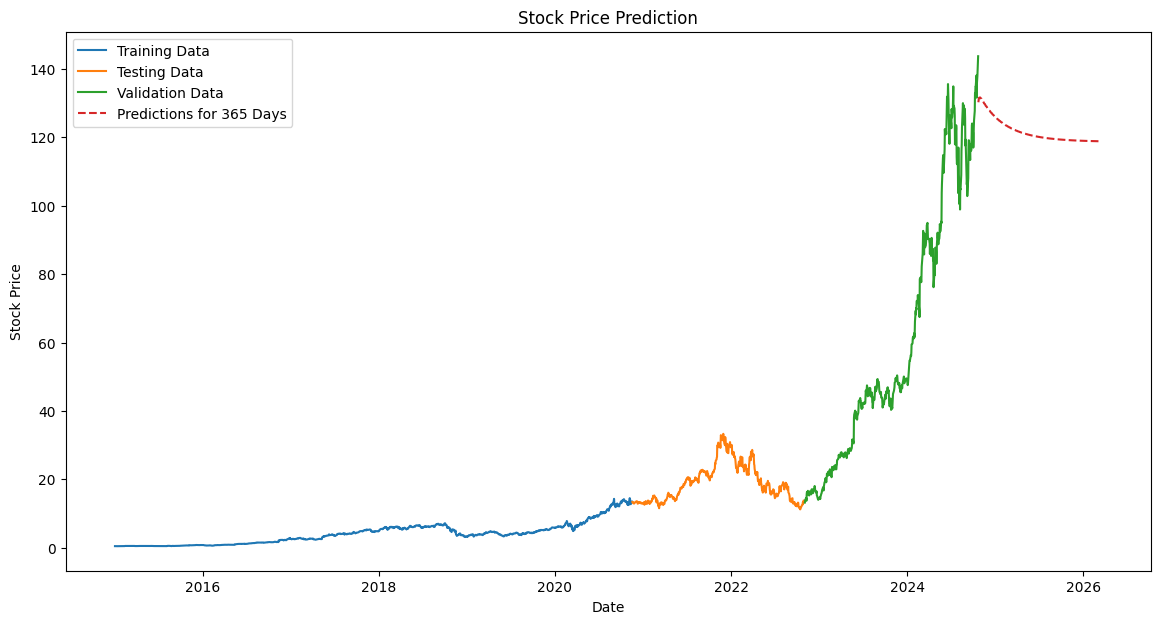

In [22]:
# Create a time-series plot of training, testing, validation, and future predictions

# Plot the training, testing, and validation data
plt.figure(figsize=(14, 7))
plt.plot(raw_data.index[:train_size], scaler.inverse_transform(train_data), label='Training Data')
plt.plot(raw_data.index[train_size:train_size + test_size], scaler.inverse_transform(test_data), label='Testing Data')
plt.plot(raw_data.index[train_size + test_size:], scaler.inverse_transform(val_data), label='Validation Data')

# Plot future predictions
prediction_index = pd.date_range(start=raw_data.index[-1], periods=prediction_days + 1, freq='B')[1:]
plt.plot(prediction_index, future_predictions, label=f'Predictions for {prediction_days} Days', linestyle='dashed')

plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()